In [1]:
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from keras.preprocessing.sequence import pad_sequences
from IPython.display import SVG, display
import pickle 
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:

from google.colab import drive
drive.mount('/content/drive')

In [0]:

data = pd.read_csv('/content/drive/My Drive/train_data.csv')
resource = pd.read_csv('/content/drive/My Drive/resources (1).csv')


In [0]:
print("Number of data points in train data", data.shape)
print('-'*50)
print("The attributes of data :", data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in train data", resource.shape)
print(resource.columns.values)
resource.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [0]:
data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [0]:
data['project_grade_category'] = data['project_grade_category'].str.replace(' ','_'
)
data['project_grade_category'] = data['project_grade_category'].str.replace('-','_'
)
data['project_grade_category'] = data['project_grade_category'].str.lower()
data['project_grade_category'].value_counts()


grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [0]:
data['project_subject_categories'] =data['project_subject_categories'].str.replace(' The ','')
data['project_subject_categories'] =data['project_subject_categories'].str.replace(' ','')
data['project_subject_categories'] =data['project_subject_categories'].str.replace('&','_')
data['project_subject_categories'] =data['project_subject_categories'].str.replace(',','_')
data['project_subject_categories'] = data['project_subject_categories'].str.lower()


In [0]:
data['teacher_prefix']=data['teacher_prefix'].fillna('Mrs.')

data['teacher_prefix'] = data['teacher_prefix'].str.replace('.','')
data['teacher_prefix'] = data['teacher_prefix'].str.lower()

data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(' The ','')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(' ','')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace('&','_')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(',','_')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.lower()

data['school_state'] = data['school_state'].str.lower()


In [0]:
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his','himself',
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them','their',
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
            'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 
            'has', 'had', 'having','do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 
            'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
            'about', 'against', 'between', 'into', 'through', 'during','before', 'after',
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
            'again', 'further','then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
            'any', 'both', 'each', 'few', 'more','most', 'other', 'some', 'such', 'only',
            'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
            "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
            "doesn't", 'hadn',"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
            'mightn', "mightn't", 'mustn',"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
            "shouldn't", 'wasn',"wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]



In [0]:
print(" printing random reviews")
print("-"*80)
print(108, data['project_title'].values[108])
print("-"*80)
print(341, data['project_title'].values[341])
print("-"*80)
print(1100, data['project_title'].values[1100])
print("-"*80)

 printing random reviews
--------------------------------------------------------------------------------
108 Easy as 1-2-3!
--------------------------------------------------------------------------------
341 Proficiency in Scientific Presentations
--------------------------------------------------------------------------------
1100 \"Reading is Dreaming with Open Eyes!\"
--------------------------------------------------------------------------------


In [0]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

preprocessed_titles = preprocess_text(data['project_title'].values)
print("printing some random reviews")
print(108, preprocessed_titles[108])
print(341, preprocessed_titles[341])
print(1147, preprocessed_titles[1147])


100%|██████████| 109248/109248 [00:02<00:00, 43932.53it/s]

printing some random reviews
108 easy 1 2 3
341 proficiency scientific presentations
1147 help hawk bots prepare stem


In [0]:
resource.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

In [0]:
data["essay"] = data["project_essay_1"].map(str) + data["project_essay_2"].map(str) + data["project_essay_3"].map(str) + data["project_essay_4"].map(str)


In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price = resource.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price.head()


,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [0]:
data = pd.merge(data, price, on='id', how='left')
data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data['price'].values.reshape(-1, 1))
data['std_price']=scaler.transform(data['price'].values.reshape(-1, 1) )

data['std_price'].head()

0   -0.390533
1    0.002396
2    0.595191
3   -0.177469
4   -0.626236
Name: std_price, dtype: float64

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data['price'].values.reshape(-1, 1))
data['norm_price']=scaler.transform(data['price'].values.reshape(-1, 1))
price_scaled= scaler.transform(data['price'].values.reshape(-1, 1))
type(price_scaled)

numpy.ndarray

In [0]:
data['norm_price'].head()

0    0.015397
1    0.029839
2    0.051628
3    0.023228
4    0.006733
Name: norm_price, dtype: float64

In [0]:
# https://github.com/mrunal46/Donors-Choose-using-LSTM/blob/master/LSTM%20on%20Donor's%20Choose%20-%20Model%201-Copy1.ipynb
def conatins_number(text):
    isdigit = any(char.isdigit() for char in text)
    if isdigit == True :
        return 1
    elif isdigit == False :
        return 0
    return 0
contains_number = data['project_resource_summary'].map(lambda x : conatins_number(x))
data['numerical_data'] = contains_number

data.drop(columns = ['project_title', 'project_essay_1', 'project_essay_2','project_essay_3', 'project_essay_4','Unnamed: 0', 'id', 'teacher_id','project_submitted_datetime', 'project_resource_summary'], inplace= True)


In [0]:
data['essay'].head()

0    My students are English learners that are work...
1    Our students arrive to our school eager to lea...
2    \r\n\"True champions aren't always the ones th...
3    I work at a unique school filled with both ESL...
4    Our second grade classroom next year will be m...
Name: essay, dtype: object

In [0]:
from sklearn.model_selection import train_test_split
Y = data['project_is_approved']
X = data.drop(columns = ['project_is_approved'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=123, shuffle= True)



In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['essay'])
train_essay_token = tokenizer.texts_to_sequences(x_train['essay'])
test_essay_token = tokenizer.texts_to_sequences(x_test['essay'])


len(tokenizer.word_index)

61737

In [0]:

padded_train = pad_sequences(train_essay_token,maxlen=1500,padding='post', truncating='post')
padded_test = pad_sequences(test_essay_token,maxlen=1500,padding='post', truncating='post')


In [0]:
glove_pickel = open("/content/drive/My Drive/glove_vectors","rb")
glove_ = pickle.load(glove_pickel)

In [0]:
embedded = np.zeros((61738, 300))
for word, i in tokenizer.word_index.items():
    vector = glove_.get(word)
    if vector is not None:
        embedded[i] = vector
print("Shape of ", embedded.shape)

padded_train[0:1]

Shape of  (61738, 300)


array([[ 16, 434,  73, ...,   0,   0,   0]], dtype=int32)

In [0]:
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding
from keras.layers.recurrent import LSTM
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model, load_model

In [0]:
#https://stackoverflow.com/questions/56097089/how-to-fix-name-embedding-is-not-defined-in-keras

embedded_layer = Embedding(61738,300,weights=[embedded],input_length=1500,trainable=False)


input_text = Input(shape=(1500,),name="input_text")
x_1 = embedded_layer(input_text)
x_1 = LSTM(128, return_sequences=True)(x_1)
flat_text = Flatten()(x_1)


In [0]:
## School state

le = preprocessing.LabelEncoder()
le_train = le.fit_transform(x_train["school_state"])
le_test = le.transform(x_test["school_state"])
input_state = Input(shape=(1,),name= "school_state")
layer_state = Embedding(51,2,trainable=True)(input_state)
flat_state = Flatten()(layer_state)

## project grades

le = preprocessing.LabelEncoder()
le_train_grade = le.fit_transform(x_train['project_grade_category'])
le_test_grade = le.transform(x_test['project_grade_category'])

number_of_unique_grades = len(x_train['project_grade_category'].unique().tolist())
input_data_grades = Input(shape=(1,),name="project_grade_category")
layer_grade = Embedding(4,2,trainable=True)(input_data_grades)
flat_grade = Flatten()(layer_grade)

## project sub categories 

le = preprocessing.LabelEncoder()
le_train_sub_category = le.fit_transform(x_train['project_subject_categories'])
le_test_sub_category = le.transform(x_test['project_subject_categories'])
input_data_sub_categories = Input(shape=(1,),name="project_subject_categories")
layer_sub_category = Embedding(51,26,trainable=True)(input_data_sub_categories)
flat_sub_category = Flatten()(layer_sub_category)

##  project sub categories

# Reference https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = preprocessing.LabelEncoder()
le.fit(x_train["project_subject_categories"])
x_test["project_subject_categories"] = x_test["project_subject_categories"].map(lambda x: 'unknown' if x not in le.classes_ else x)
le.classes_ = np.append(le.classes_, 'unknown')
le_train_sub_sub_category = le.transform(x_train["project_subject_categories"])
le_test_sub_sub_category= le.transform(x_test["project_subject_categories"])

number_of_unique_sub_sub_categories = len(x_train['project_subject_subcategories'].unique().tolist())
input_data_sub_sub_category = Input(shape=(1,),name="project_subject_subcategories")
layer_sub_sub_category = Embedding(398,199,trainable=True)(input_data_sub_sub_category)
flat_sub_sub_category = Flatten()(layer_sub_sub_category)

## teacher prefix

le = preprocessing.LabelEncoder()
le_train_teacher_prefix = le.fit_transform(x_train['teacher_prefix'])
le_test_teacher_prefix = le.transform(x_test['teacher_prefix'])

input_data_teacher_prefix = Input(shape=(1,),name="teacher_prefix")
layer_teacher_prefix = Embedding(5,3,trainable=True)(input_data_teacher_prefix)
flat_teacher_prefix = Flatten()(layer_teacher_prefix)


In [0]:
combined_train = np.concatenate( (x_train["numerical_data"].values.reshape(-1, 1),x_train['price'].values.reshape(-1, 1),x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),x_train['quantity'].values.reshape(-1, 1)),axis = 1)



combined_test = np.concatenate( (x_test["numerical_data"].values.reshape(-1, 1),x_test['price'].values.reshape(-1, 1),x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),  x_test['quantity'].values.reshape(-1, 1)),axis = 1)



scaler = StandardScaler()
scaler.fit(combined_train)
combined_train = scaler.transform(combined_train)
combined_test = scaler.transform(combined_test)


input_data_combined = Input(shape=(4,),name="combined_features")
dense_num = Dense(28,activation="relu",kernel_initializer="he_normal")(input_data_combined)


In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def aucroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# Model 1

In [0]:
## Model 1

In [0]:

model = concatenate([flat_text ,dense_num, flat_sub_sub_category,flat_sub_category, flat_grade , flat_teacher_prefix , flat_state ])
model = Dense(32,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.5)(model)
model = Dense(32,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.5)(model)
model = Dense(16,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.5)(model)
model = Dense(12,activation="relu",kernel_initializer="he_normal")(model)
model = BatchNormalization()(model)
outputs = Dense(2, activation='softmax')(model)
model = Model(inputs = [input_text ,input_data_combined, input_data_sub_sub_category, input_data_sub_categories,
                         input_data_grades , input_data_teacher_prefix , input_state ],outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', aucroc])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                

In [0]:
train = [padded_train, combined_train, le_train_sub_sub_category, le_train_sub_category, le_train_grade ,le_train_teacher_prefix,le_train]
test = [padded_test, combined_test, le_test_sub_sub_category, le_test_sub_category, le_test_grade ,le_test_teacher_prefix , le_test]


# combined_features_train = np.concatenate( (X_train["numerical_data"].values.reshape(-1, 1),X_train[
# 'price'].values.reshape(-1, 1), X_train['teacher_number_of_previously_posted_projects'].values.resh
# ape(-1, 1), X_train['quantity'].values.reshape(-1, 1)),axis = 1)


# x_test = np.concatenate( (padded_train.values.reshape(-1, 1), combined_train.values.reshape(-1, 1),
#                           le_train_sub_sub_category.values.reshape(-1, 1), le_train_sub_category.values.reshape(-1, 1), 
#                le_train_grade.values.reshape(-1, 1) ,le_train_teacher_prefix.values.reshape(-1, 1),le_train.values.reshape(-1, 1)) ,axis = 1)


In [0]:
# combined_features_train = np.concatenate( (X_train["numerical_data"].values.reshape(-1, 1),X_train[
# 'price'].values.reshape(-1, 1), X_train['teacher_number_of_previously_posted_projects'].values.resh
# ape(-1, 1), X_train['quantity'].values.reshape(-1, 1)),axis = 1)


# ss_train=np.concatenate((padded_train, combined_train))
# x_train=pd.concat([pd.DataFrame(padded_train), pd.DataFrame(combined_train), pd.DataFrame(le_train_sub_sub_category)
#               , pd.DataFrame(le_train_sub_category), pd.DataFrame(le_train_grade), pd.DataFrame(le_train_teacher_prefix),
#               pd.DataFrame(le_train)], axis=1)

# x_test=pd.concat([pd.DataFrame(padded_test), pd.DataFrame(combined_test), pd.DataFrame(le_test_sub_sub_category)
#               , pd.DataFrame(le_test_sub_category), pd.DataFrame(le_test_grade), pd.DataFrame(le_test_teacher_prefix),
#               pd.DataFrame(le_test)], axis=1)

In [0]:
y_train.shape

(87398,)

In [0]:


y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
m1=model.fit(train,y_train ,batch_size=1500,epochs=5,verbose=1,validation_data=(test,y_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 87398 samples, validate on 21850 samples
Epoch 1/5
87398/87398 [==============================] - 261s 3ms/step - loss: 0.7384 - acc: 0.6728 - aucroc: 0.5013 - val_loss: 0.6165 - val_acc: 0.8227 - val_aucroc: 0.4670
Epoch 2/5
87398/87398 [==============================] - 252s 3ms/step - loss: 0.5434 - acc: 0.8409 - aucroc: 0.5012 - val_loss: 0.4963 - val_acc: 0.8467 - val_aucroc: 0.5390
Epoch 3/5
87398/87398 [==============================] - 252s 3ms/step - loss: 0.4732 - acc: 0.8434 - aucroc: 0.5208 - val_loss: 0.4516 - val_acc: 0.8467 - val_aucroc: 0.5341
Epoch 4/5
87398/87398 [==============================] - 252s 3ms/step - loss: 0.4395 - acc: 0.8476 - aucroc: 0.5221 - val_loss: 0.4348 - val_acc: 0.8467 - val_aucroc: 0.5168
Epoch 5/5
87398/87398 [==============================] - 252s 3ms/step - loss: 0.4291 - acc: 0.8484 - aucroc: 0.5273 - val_loss: 0.4284 - val_acc: 0.8467 

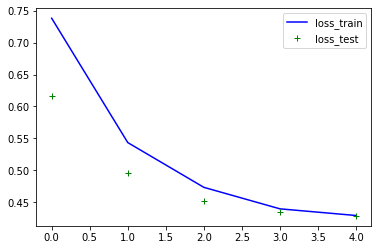

In [0]:

plt.plot(m1.history['loss'], 'b-')
plt.plot(m1.history['val_loss'], 'g+')
plt.legend({'loss_train': 'b', 'loss_test':'p='})
plt.show()

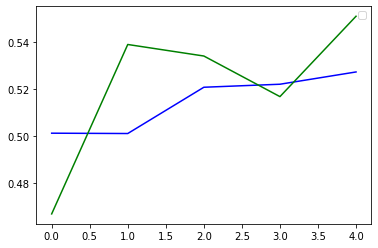

In [0]:
plt.legend({'train_roc_auc': 'b', 'test_roc_auc':'g'})
plt.plot(m1.history['aucroc'], 'b')
plt.plot(m1.history['val_aucroc'], 'g')
plt.show()


# Model 2

In [0]:
## model 2

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(x_train['essay'])
test_tfidf = tfidf.transform(x_test['essay'])
import seaborn as sns

In [0]:
dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))

box plot of tfidf 



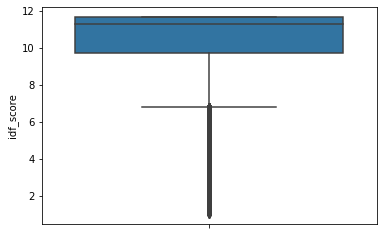

In [0]:
df_tfidf = pd.DataFrame(list(dictionary.items()), columns=['words', 'idf_score'])
df_tfidf.sort_values(by ='idf_score', inplace = True)
print("box plot of tfidf \n")
sns.boxplot(y="idf_score", data=df_tfidf)

box plot of tfidf 



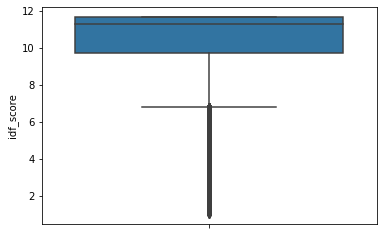

In [0]:
print("box plot of tfidf \n")
sns.boxplot(y="idf_score", data=df_tfidf)

In [0]:
## School state

le = preprocessing.LabelEncoder()
le_train = le.fit_transform(x_train["school_state"])
le_test = le.transform(x_test["school_state"])
input_state = Input(shape=(1,),name= "school_state")
layer_state = Embedding(51,2,trainable=True)(input_state)
flat_state = Flatten()(layer_state)

## project grades

le = preprocessing.LabelEncoder()
le_train_grade = le.fit_transform(x_train['project_grade_category'])
le_test_grade = le.transform(x_test['project_grade_category'])

number_of_unique_grades = len(x_train['project_grade_category'].unique().tolist())
input_data_grades = Input(shape=(1,),name="project_grade_category")
layer_grade = Embedding(4,2,trainable=True)(input_data_grades)
flat_grade = Flatten()(layer_grade)

## project sub categories 

le = preprocessing.LabelEncoder()
le_train_sub_category = le.fit_transform(x_train['project_subject_categories'])
le_test_sub_category = le.transform(x_test['project_subject_categories'])
input_data_sub_categories = Input(shape=(1,),name="project_subject_categories")
layer_sub_category = Embedding(51,26,trainable=True)(input_data_sub_categories)
flat_sub_category = Flatten()(layer_sub_category)

##  project sub categories

# Reference https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = preprocessing.LabelEncoder()
le.fit(x_train["project_subject_categories"])
x_test["project_subject_categories"] = x_test["project_subject_categories"].map(lambda x: 'unknown' if x not in le.classes_ else x)
le.classes_ = np.append(le.classes_, 'unknown')
le_train_sub_sub_category = le.transform(x_train["project_subject_categories"])
le_test_sub_sub_category= le.transform(x_test["project_subject_categories"])

number_of_unique_sub_sub_categories = len(x_train['project_subject_subcategories'].unique().tolist())
input_data_sub_sub_category = Input(shape=(1,),name="project_subject_subcategories")
layer_sub_sub_category = Embedding(398,199,trainable=True)(input_data_sub_sub_category)
flat_sub_sub_category = Flatten()(layer_sub_sub_category)

## teacher prefix

le = preprocessing.LabelEncoder()
le_train_teacher_prefix = le.fit_transform(x_train['teacher_prefix'])
le_test_teacher_prefix = le.transform(x_test['teacher_prefix'])

input_data_teacher_prefix = Input(shape=(1,),name="teacher_prefix")
layer_teacher_prefix = Embedding(5,3,trainable=True)(input_data_teacher_prefix)
flat_teacher_prefix = Flatten()(layer_teacher_prefix)


In [0]:
combined_train = np.concatenate( (x_train["numerical_data"].values.reshape(-1, 1),
                                           x_train['price'].values.reshape(-1, 1),
                                           x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),
                                           x_train['quantity'].values.reshape(-1, 1)),axis = 1)



combined_test = np.concatenate( (x_test["numerical_data"].values.reshape(-1, 1),
                                          x_test['price'].values.reshape(-1, 1),
                                          x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),
                                          x_test['quantity'].values.reshape(-1, 1)),axis = 1)



scaler = StandardScaler()
scaler.fit(combined_train)
combined_train = scaler.transform(combined_train)
combined_test = scaler.transform(combined_test)


input_data = Input(shape=(4,),name="combined_features")
dense_num = Dense(28,activation="relu",kernel_initializer="he_normal")(input_data)

In [0]:
model = concatenate([flat_text ,dense_num, flat_2_sub_category,flat_sub_category, flat_grade , flat_teacher_prefix , flat_state ])
model = Dense(32,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.5)(model)
model = Dense(16,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.3)(model)
model = Dense(12,activation="relu",kernel_initializer="he_normal")(model)
model = BatchNormalization()(model)
outputs = Dense(2, activation='softmax')(model)
model_2 = Model(inputs = [input_text ,input_data, input_data_2_sub_category, input_data_sub_categories, input_data_grades , input_data_teacher_prefix , input_state ],outputs=outputs)

In [0]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1500, 300)    18521400    input_text[0][0]                 
__________________________________________________________________________________________________
project_subject_subcategories ( (None, 1)            0                                            
__________________________________________________________________________________________________
project_subject_categories (Inp (None, 1)            0                                            
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', aucroc])

In [0]:
m = model.fit(train,y_train ,batch_size=1500,epochs=8,verbose=1,validation_data=(test,y_test))

Train on 87398 samples, validate on 21850 samples
Epoch 1/8
87398/87398 [==============================] - 251s 3ms/step - loss: 0.7139 - acc: 0.6813 - aucroc: 0.5058 - val_loss: 0.5615 - val_acc: 0.8467 - val_aucroc: 0.5329
Epoch 2/8
87398/87398 [==============================] - 248s 3ms/step - loss: 0.5524 - acc: 0.8332 - aucroc: 0.5089 - val_loss: 0.5166 - val_acc: 0.8467 - val_aucroc: 0.5181
Epoch 3/8
87398/87398 [==============================] - 249s 3ms/step - loss: 0.4777 - acc: 0.8476 - aucroc: 0.5109 - val_loss: 0.4538 - val_acc: 0.8467 - val_aucroc: 0.5462
Epoch 4/8
87398/87398 [==============================] - 248s 3ms/step - loss: 0.4388 - acc: 0.8488 - aucroc: 0.5244 - val_loss: 0.4372 - val_acc: 0.8467 - val_aucroc: 0.5104
Epoch 5/8
87398/87398 [==============================] - 248s 3ms/step - loss: 0.4413 - acc: 0.8469 - aucroc: 0.5215 - val_loss: 0.4286 - val_acc: 0.8467 - val_aucroc: 0.5549
Epoch 6/8
87398/87398 [==============================] - 249s 3ms/step - lo

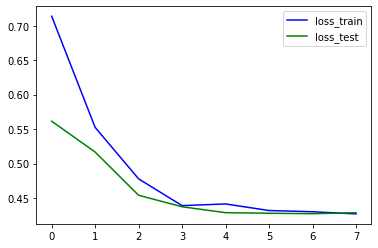

In [0]:
#loss graph
plt.plot(m.history['loss'], 'b')
plt.plot(m.history['val_loss'], 'g')
plt.legend({'loss_train': 'b', 'loss_test':'g'})
plt.show()


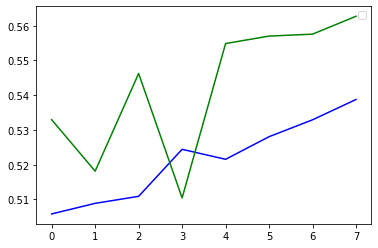

In [0]:
plt.legend({'train_roc_auc': 'b', 'test_roc_auc':'g'})
plt.plot(m.history['aucroc'], 'b')
plt.plot(m.history['val_aucroc'], 'g')
plt.show()

# Model 3

In [0]:
## Model 3

In [0]:
train_essay_len = (x_train['essay'].apply(len))
test_essay_len = (x_test['essay'].apply(len))

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['essay'])
train_essay_token = tokenizer.texts_to_sequences(x_train['essay'])
test_essay_token = tokenizer.texts_to_sequences(x_test['essay'])

len(tokenizer.word_index)

61737

In [0]:
padded_train = pad_sequences(train_essay_token,maxlen=1500,padding='post', truncating='post')
padded_test = pad_sequences(test_essay_token,maxlen=1500,padding='post', truncating='post')

embedded = np.zeros((61738, 300))
for word, i in tokenizer.word_index.items():
  vector = glove_.get(word)
  if vector is not None:
    embedded[i] = vector
print(embedded.shape)



(61738, 300)


In [0]:
x_train.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'essay', 'price',
       'quantity', 'std_price', 'noOrm_price', 'norm_price', 'numerical_data'],
      dtype='object')

In [0]:
embedded_layer = Embedding(61738,300,weights=[embedded],input_length=1500,trainable=False)
input_text_ = Input(shape=(1500,),name="input_text_")
x = embedded_layer(input_text_)
x = LSTM(128, return_sequences=True)(x)
flat_text = Flatten()(x)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
train_teacher_prefix = bow.fit_transform(x_train['teacher_prefix'])
test_teacher_prefix = bow.transform(x_test['teacher_prefix'])

bow = CountVectorizer()
train_school_state = bow.fit_transform(x_train['school_state'])
test_school_state = bow.transform(x_test['school_state'])

bow = CountVectorizer()
train_project_grade_category = bow.fit_transform(x_train['project_grade_category'])
test_project_grade_category = bow.transform(x_test['project_grade_category'])


bow = CountVectorizer()
train_project_subject_categories = bow.fit_transform(x_train['project_subject_categories'])
test_project_subject_categories = bow.transform(x_test['project_subject_categories'])

bow = CountVectorizer()
train_project_subject_subcategories = bow.fit_transform(x_train['project_subject_subcategories'])
test_project_subject_subcategories = bow.transform(x_test['project_subject_subcategories'])


from scipy.sparse import hstack
train_except_essay = hstack([train_teacher_prefix,train_school_state,train_project_grade_category,train_project_subject_categories,train_project_subject_subcategories]).todense()
test_except_essay = hstack([test_teacher_prefix,test_school_state,test_project_grade_category,test_project_subject_categories,test_project_subject_subcategories]).todense()

In [0]:
combined_features_train = np.concatenate( (x_train["numerical_data"].values.reshape(-1, 1),x_train['price'].values.reshape(-1, 1), x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1), x_train['quantity'].values.reshape(-1, 1)),axis = 1)
combined_features_test = np.concatenate( (x_test["numerical_data"].values.reshape(-1, 1),x_test['price'].values.reshape(-1, 1), x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1), x_test['quantity'].values.reshape(-1, 1)),axis = 1)


In [0]:
combined_features_train.shape

(87398, 4)

In [0]:

combined_train = np.concatenate( (x_train["numerical_data"].values.reshape(-1, 1),x_train['price'].values.reshape(-1, 1), x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1), x_train['quantity'].values.reshape(-1, 1)),axis = 1)
combined_test = np.concatenate( (x_test["numerical_data"].values.reshape(-1, 1),x_test['price'].values.reshape(-1, 1), x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1), x_test['quantity'].values.reshape(-1, 1)),axis = 1)

#standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaler.fit(combined_features_train)

combined_train_features = scaler.fit_transform(combined_train)
combined_test_features = scaler.transform(combined_test)


In [0]:
combined_train = np.matrix(combined_train_features)
combined_test = np.matrix(combined_test_features)

In [0]:
from scipy import sparse
combined_train_matrix = sparse.csr_matrix(combined_train)
combined_test_matrix = sparse.csr_matrix(combined_test)

In [0]:
from scipy.sparse import hstack
train_except_essay = hstack([train_teacher_prefix,train_school_state,train_project_grade_category,train_project_subject_categories,train_project_subject_subcategories]).todense()
test_except_essay  = hstack([test_teacher_prefix,test_school_state,test_project_grade_category,test_project_subject_categories,test_project_subject_subcategories]).todense()

In [0]:
train_sparse = hstack([train_except_essay,combined_train_matrix])
test_sparse = hstack([test_except_essay,combined_test_matrix])

In [0]:
train_dense = train_sparse.todense()
test_dense = test_sparse.todense()

In [0]:
train = np.expand_dims(train_dense,2)
test = np.expand_dims(test_dense,2)

In [0]:
# https://stackoverflow.com/questions/54542682/how-to-properly-pass-2d-array-to-conv1d?answertab=votes#tab-top
from keras.layers.convolutional import Conv1D, MaxPooling1D
input_text = Input(shape=(513,1),name="input_text")
x_ = Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer="he_normal")(input_text)
x_ = Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer="he_normal")(x_)
x_flat = Flatten()(x_)

model = concatenate([flat_text,x_flat])

model = Dense(64,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.5)(model)
model = Dense(32,activation="relu",kernel_initializer="he_normal")(model)
model = Dropout(0.2)(model)
model = Dense(16,activation="relu",kernel_initializer="he_normal")(model)
outputs = Dense(2, activation='softmax')(model)
model = Model(inputs = [input_text_,input_text  ],outputs= outputs)

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_ (InputLayer)        (None, 1500)         0                                            
__________________________________________________________________________________________________
input_text (InputLayer)         (None, 513, 1)       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1500, 300)    18521400    input_text_[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 511, 64)      256         input_text[0][0]                 
____________________________________________________________________________________________

In [0]:
# reference https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', aucroc])

In [0]:
# train_model = hstack([padded_train,train])
# test_model = hstack([padded_test,test])

In [0]:
padded_train.shape

(87398, 1500)

In [0]:

m3 = model.fit(train_model,y_train ,batch_size=1000,epochs=5,verbose=1,validation_data=(test_model,y_test))


Train on 87398 samples, validate on 21850 samples
Epoch 1/5
87398/87398 [==============================] - 346s 4ms/step - loss: 0.4639 - acc: 0.8350 - aucroc: 0.5990 - val_loss: 0.4295 - val_acc: 0.8467 - val_aucroc: 0.7136
Epoch 2/5
87398/87398 [==============================] - 350s 4ms/step - loss: 0.3950 - acc: 0.8490 - aucroc: 0.7079 - val_loss: 0.4200 - val_acc: 0.8467 - val_aucroc: 0.7485
Epoch 3/5
87398/87398 [==============================] - 439s 5ms/step - loss: 0.3748 - acc: 0.8510 - aucroc: 0.7497 - val_loss: 0.4035 - val_acc: 0.8482 - val_aucroc: 0.7574
Epoch 4/5
87398/87398 [==============================] - 563s 6ms/step - loss: 0.3603 - acc: 0.8544 - aucroc: 0.7768 - val_loss: 0.3967 - val_acc: 0.8525 - val_aucroc: 0.7563
Epoch 5/5
87398/87398 [==============================] - 400s 5ms/step - loss: 0.3452 - acc: 0.8592 - aucroc: 0.8010 - val_loss: 0.3907 - val_acc: 0.8515 - val_aucroc: 0.7512


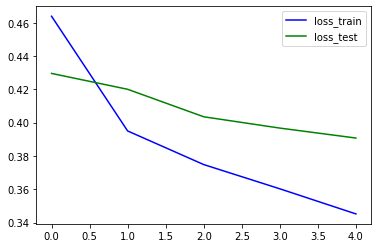

In [0]:
#loss graph
plt.plot(m3.history['loss'], 'b')
plt.plot(m3.history['val_loss'], 'g')
plt.legend({'loss_train': 'b', 'loss_test':'g'})
plt.show()


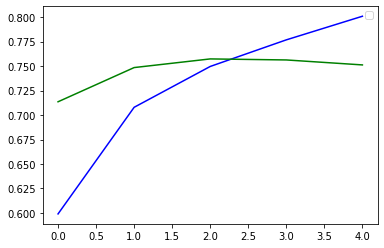

In [0]:
plt.legend({'train_roc_auc': 'b', 'test_roc_auc':'g'})
plt.plot(m3.history['aucroc'], 'b')
plt.plot(m3.history['val_aucroc'], 'g')
plt.show()

In [0]:
pip install PrettyTable


In [0]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names=["Models", "number of Epochs", "accuracy", "roc",]
table.add_row(["1", "5", "0.8467 ", "0.5510"])
table.add_row(["2", "8", "0.8467 ", "0.5627"])
table.add_row(["3", "5", "0.8515 ", "0.7512"])
print(table)


+--------+------------------+----------+--------+
| Models | number of Epochs | accuracy |  roc   |
+--------+------------------+----------+--------+
|   1    |        5         | 0.8467   | 0.5510 |
|   2    |        8         | 0.8467   | 0.5627 |
|   3    |        5         | 0.8515   | 0.7512 |
+--------+------------------+----------+--------+
